In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import uniform, randint
import pickle


from data.create_data_df import create_data_df

In [3]:
tss = TimeSeriesSplit(n_splits=6, test_size=24*2*14, )


In [4]:
df = create_data_df()
df = df.set_index('Datetime')
print(type(df.index))
df = df.sort_index()
df = df.dropna()
df.head(10)


/Users/alextseng/Documents/ucy-pv-forecasting/data/create_data_df.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2022_2023 = pd.read_csv('./data/UCYdemo_2022_2023.csv', parse_dates=[0])


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Tamb,RH,POA,Pac
Datetime,,,,
2019-01-01 00:00:00,12.98,90.4,0.038,0.001474
2019-01-01 00:30:00,13.14,88.6,0.068,0.001412
2019-01-01 01:00:00,13.37,84.4,0.563,0.001670
2019-01-01 01:30:00,13.79,94.9,0.023,0.001537
2019-01-01 02:00:00,14.01,96.7,0.000,0.001181
2019-01-01 02:30:00,14.11,96.7,0.000,0.001461
2019-01-01 03:00:00,14.20,97.3,0.000,0.001353
2019-01-01 03:30:00,14.19,98.2,0.000,0.001747
2019-01-01 04:00:00,14.24,98.8,0.000,0.001543


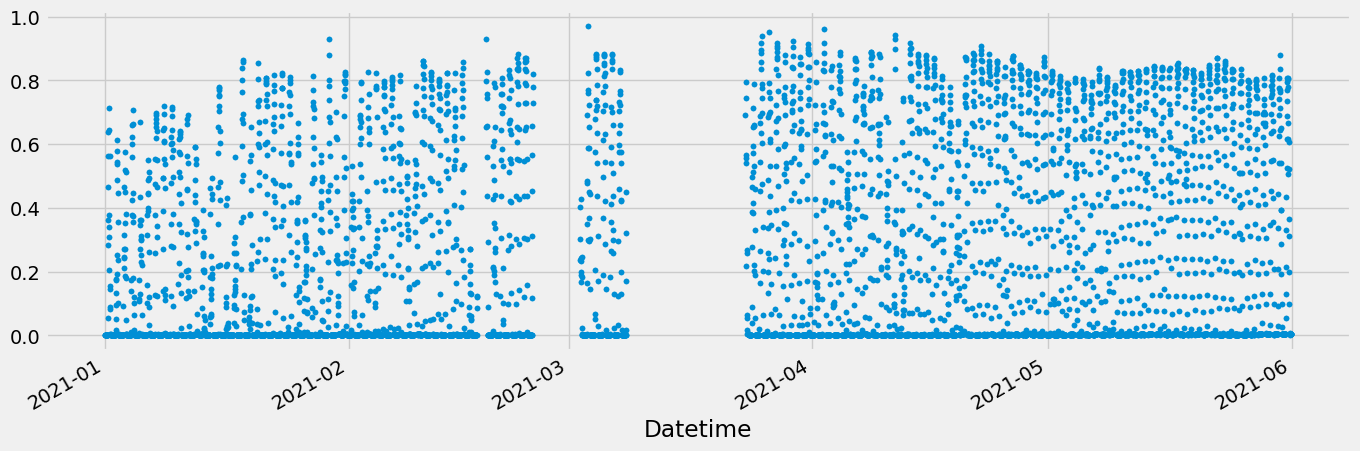

In [5]:
_ = df['2021-1':'2021-5']['Pac'].plot(style='.', figsize=(15,5))

In [6]:
def create_features(df, label=None):
    _df = df.copy()
    """
    Creates time series features from datetime index
    """
    _df['date'] = _df.index
    _df['min'] = _df['date'].dt.hour * 60 + _df['date'].dt.minute
    #df['dayofweek'] = df['date'].dt.dayofweek
    _df['quarter'] = _df['date'].dt.quarter
    _df['month'] = _df['date'].dt.month
    #df['year'] = df['date'].dt.year
    _df['dayofyear'] = _df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    _df['weekofyear'] = _df['date'].dt.isocalendar().week
    
    X = _df[['min','month',
           'dayofyear','weekofyear', 'quarter', 'Tamb', 'RH', 'POA']]
    if label:
        y = _df[label]
        return X, y
    return X

In [6]:
# Create df's for hyperparameter tuning
X_tune, y_tune = create_features(df, label='Pac')

In [33]:
# Hyperparameter tuning with RandomSearch

# Define the model
rand_search_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define the parameter distribution for Random Search
param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rand_search_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_tune, y_tune)

# Print best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score (neg MSE): ", random_search.best_score_)


Best parameters found:  {'colsample_bytree': 0.681814801189647, 'gamma': 0.48589104136048034, 'learning_rate': 0.2987341884826334, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 485, 'reg_alpha': 0.712270589924442, 'reg_lambda': 0.1480869299533999, 'subsample': 0.9988702425244709}
Best score (neg MSE):  -0.0022735357080101402


In [ ]:
# Hyperparameter tuning with GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [random_search.best_params_['max_depth'] - 1, random_search.best_params_['max_depth'], random_search.best_params_['max_depth'] + 1],
    'min_child_weight': [random_search.best_params_['min_child_weight'] - 1, random_search.best_params_['min_child_weight'], random_search.best_params_['min_child_weight'] + 1],
    'gamma': [random_search.best_params_['gamma'] - 0.1, random_search.best_params_['gamma'], random_search.best_params_['gamma'] + 0.1],
    'subsample': [random_search.best_params_['subsample'] - 0.1, random_search.best_params_['subsample'], random_search.best_params_['subsample'] + 0.1],
    'colsample_bytree': [random_search.best_params_['colsample_bytree'] - 0.1, random_search.best_params_['colsample_bytree'], random_search.best_params_['colsample_bytree'] + 0.1],
    'learning_rate': [random_search.best_params_['learning_rate'] - 0.05, random_search.best_params_['learning_rate'], random_search.best_params_['learning_rate'] + 0.05],
    'n_estimators': [random_search.best_params_['n_estimators'] - 50, random_search.best_params_['n_estimators'], random_search.best_params_['n_estimators'] + 50]
}

# Create the XGBoost model object
grid_search_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Create the GridSearchCV object
grid_search = GridSearchCV(grid_search_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_tune, y_tune)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score (neg MSE): ", grid_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.7238110465145311, 'gamma': 0.3068975098534743, 'learning_rate': 0.26541935176616377, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 352, 'subsample': 0.9324650484723305}
Best score (neg MSE):  -0.002135757464144115


In [ ]:
# Save grid_search.best_params_
with open('hyper_params/xgboost_pv_p_grid_search_best_params.pkl', 'wb') as file:
    pickle.dump(grid_search.best_params_, file)

# Save random_search.best_params_
with open('hyper_params/xgboost_pv_p_random_search_best_params.pkl', 'wb') as file:
    pickle.dump(random_search.best_params_, file)

In [7]:
# Time series cross validation testing

fold = 0
preds = []
scores = []
pred_indxs = []
regs = []
# tuned_preds = []

for train_idx, test_idx in tss.split(df):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    pred_indxs.append(test_idx)

    X_train, y_train = create_features(df_train, label='Pac')
    X_test, y_test = create_features(df_test, label='Pac')

    reg = xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror', n_jobs=-1)
    reg.set_params(
    eval_metric='rmse',
    early_stopping_rounds=50
    )
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    regs.append(reg)
    y_pred = reg.predict(X_test)
    # y_tuned_pred = random_search.best_estimator_.predict(X_test)
    preds.append(y_pred)
    # tuned_preds.append(y_tuned_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Average RMSE: {np.mean(scores)}')
print(f'Individual RMSE Scores: {scores}')


[0]	validation_0-rmse:0.20201	validation_1-rmse:0.18753
[100]	validation_0-rmse:0.00691	validation_1-rmse:0.00625
[172]	validation_0-rmse:0.00585	validation_1-rmse:0.00638
[0]	validation_0-rmse:0.20195	validation_1-rmse:0.17789
[93]	validation_0-rmse:0.00689	validation_1-rmse:0.00638
[0]	validation_0-rmse:0.20183	validation_1-rmse:0.16805
[61]	validation_0-rmse:0.00760	validation_1-rmse:0.00837
[0]	validation_0-rmse:0.20166	validation_1-rmse:0.18169
[100]	validation_0-rmse:0.00687	validation_1-rmse:0.00836
[134]	validation_0-rmse:0.00631	validation_1-rmse:0.00854
[0]	validation_0-rmse:0.20156	validation_1-rmse:0.16097
[100]	validation_0-rmse:0.00691	validation_1-rmse:0.00762
[193]	validation_0-rmse:0.00562	validation_1-rmse:0.00761
[0]	validation_0-rmse:0.20136	validation_1-rmse:0.18059
[100]	validation_0-rmse:0.00692	validation_1-rmse:0.00757
[102]	validation_0-rmse:0.00689	validation_1-rmse:0.00754
Average RMSE: 0.007208357579406996
Individual RMSE Scores: [0.0062109665578461756, 0.0

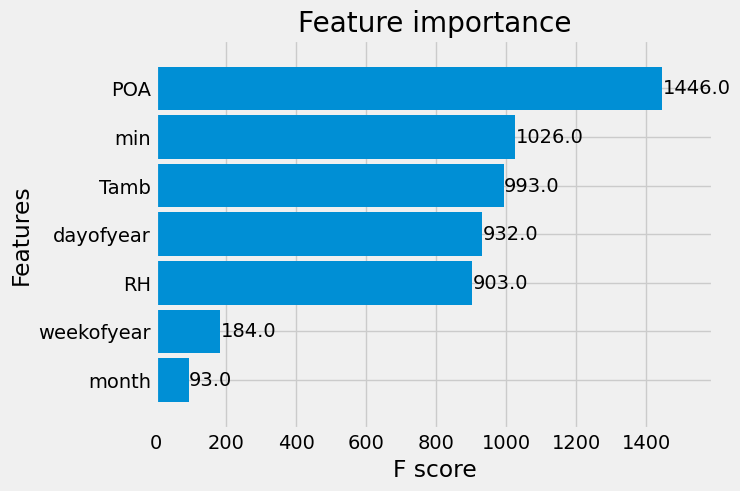

In [8]:
_ = plot_importance(reg, height=0.9)


In [9]:
PRED_NUM = 5

df_with_preds = df.iloc[pred_indxs[PRED_NUM]].copy()
df_with_preds['Pac_pred'] = preds[PRED_NUM]
df_with_preds.head(5)


,Tamb,RH,POA,Pac,Pac_pred
Datetime,,,,,
2023-12-18 00:00:00,15.94,41.50,0.0,0.002,0.002009
2023-12-18 00:30:00,15.52,43.28,0.0,0.002,0.002257
2023-12-18 01:00:00,15.05,44.68,0.0,0.002,0.002257
2023-12-18 01:30:00,14.66,44.85,0.0,0.002,0.002257
2023-12-18 02:00:00,14.33,45.88,0.0,0.002,0.002257


In [10]:
mean_squared_error(y_true=df_with_preds['Pac'],
                   y_pred=df_with_preds['Pac_pred'])

5.482932442194463e-05

In [11]:
mean_absolute_error(y_true=df_with_preds['Pac'],
                   y_pred=df_with_preds['Pac_pred'])

0.003448504978923924

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
# The 0.05 parameter eliminates distortionary divide by zero values
error = mean_absolute_percentage_error(y_true=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac']
,
                   y_pred=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac_pred'])

error

1.4969613969829516

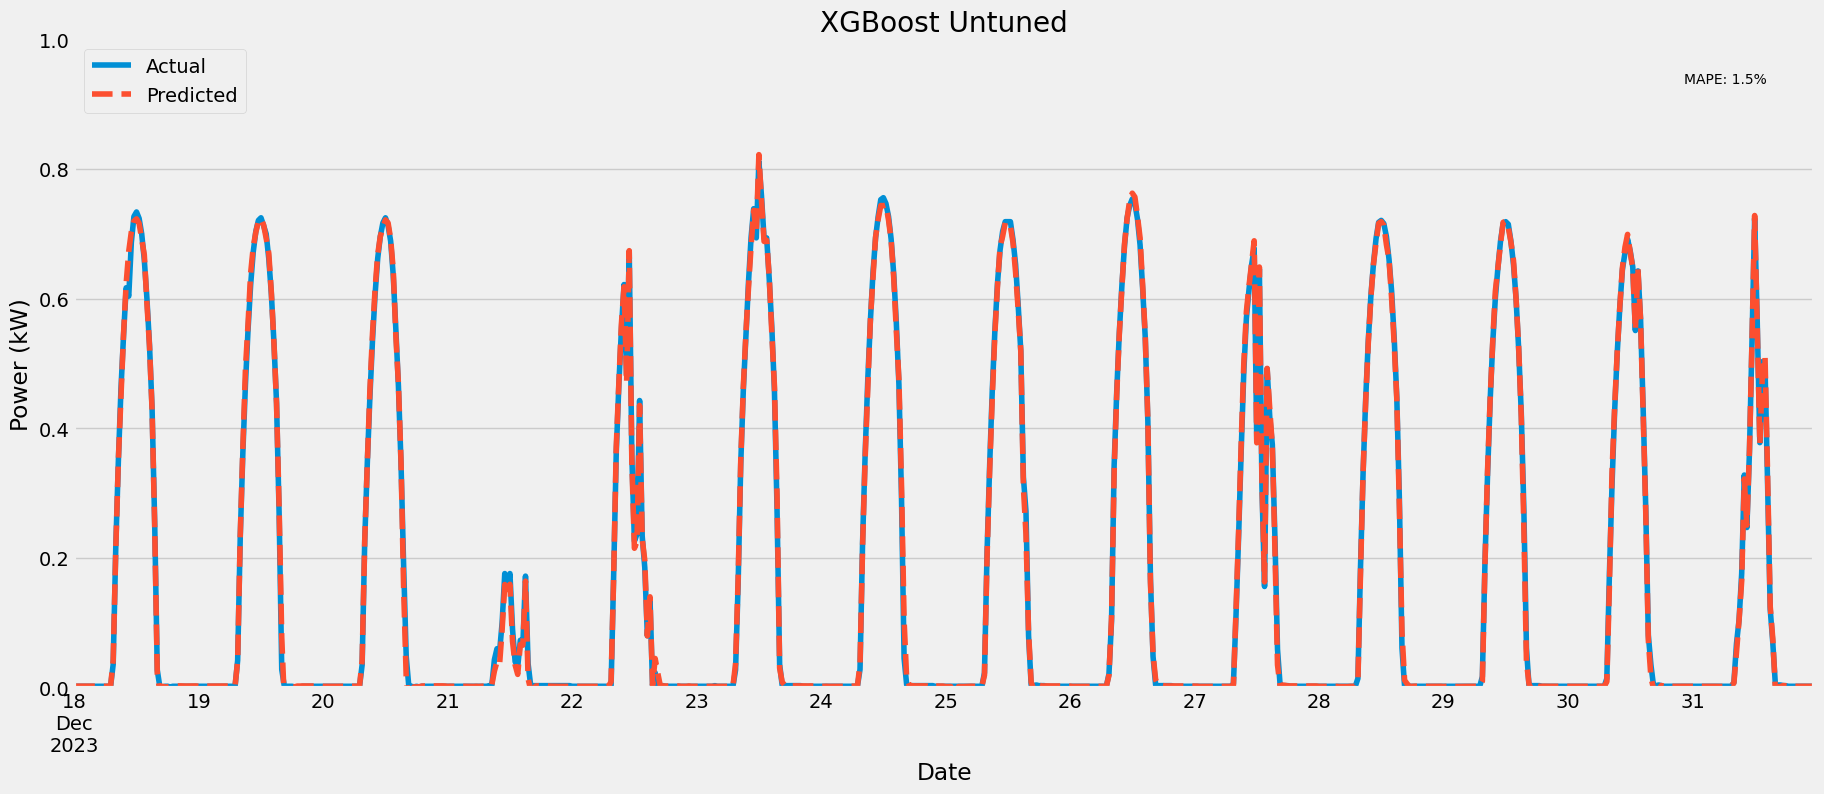

In [15]:
# Plot the data
_ = df_with_preds.plot(y=['Pac', 'Pac_pred'], figsize=(20,8), title="XGBoost Untuned", style=['-','--'])

# Add y-axis label
plt.ylabel('Power (kW)')

# Add x-axis label
plt.xlabel('Date')
plt.legend(['Actual', 'Predicted'])
# Display the error value
plt.text(0.925, 0.95, f"MAPE: {error:.1f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.ylim(0, 1)

# Show the plot
plt.show()


In [ ]:

# Load the best_params_ objects from their pickle files
with open('hyper_params/xgboost_pv_p_grid_search_best_params.pkl', 'rb') as file:
    best_params_gridsearch = pickle.load(file)

with open('hyper_params/xgboost_pv_p_random_search_best_params.pkl', 'rb') as file:
    best_params_randomizedsearch = pickle.load(file)

In [18]:
X_total_test, _ = create_features(df, label='Pac')
df_with_preds = df.copy()
# df_with_preds['Pac_pred'] = random_search.best_estimator_.predict(X_total_test)
# mean_absolute_percentage_error(
#     y_true=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac'], 
#     y_pred=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac_pred']
#     )


In [19]:
sum = np.zeros(X_total_test.shape[0])
scores = np.array(scores)
inv_scores = 1 / scores
print(inv_scores)
tot_weight = np.sum(inv_scores)
for i, reg in enumerate(regs):
    print(f'Weight: {inv_scores[i] / tot_weight}')
    sum += reg.predict(X_total_test) * (inv_scores[i] / tot_weight)

df_with_preds['Pac_pred2'] = sum 

mean_absolute_percentage_error(
    y_true=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac'], 
    y_pred=df_with_preds.loc[df_with_preds['Pac'] > 0.2, 'Pac_pred2']
    )


[160.71058409 178.80454954 121.02804917 120.35546842 131.01931725
 135.04967787]
Weight: 0.18974819732789455
Weight: 0.21111142829967125
Weight: 0.14289571708339555
Weight: 0.14210161266155305
Weight: 0.154692233899011
Weight: 0.15945081072847458


1.4388974151087206

In [26]:
django_test_df = X_total_test.loc['2019-01-01'].copy()
django_test_df['Pac_pred'] = df_with_preds.loc['2019-01-01']['Pac_pred2']
django_test_df.to_csv('forecast_pv_test_df.csv')


In [37]:
# save each regressor to its own file
for i, reg in enumerate(regs):
    reg.save_model(f'xgboost_model_{i}.bin')
        

/Users/alextseng/Documents/ucy-pv-forecasting/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
